# MOA Evaluation using enrichment analysis

- Adopted here: https://www.nature.com/articles/s41467-019-10154-8
- Explained here: https://yulab-smu.github.io/clusterProfiler-book/chapter2.html

### Procedure:
1. Compute similarity / correlation / affinity matrix
1. Define MOA matching criteria based on metadata
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L67
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L190
1. Find the threshold of top connections (percentile)
1. Run enrichment analysis (one-sided version of Fisher's exact test)
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L97
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L205

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import sys
import sklearn

sys.path.append("../profiling/")

import metrics
import quality
import profiling

# Load correlation matrix

In [2]:
SIM_MATRIX = "data/mixed_validation_matrix.csv"
OUT_RESUTS =  "data/mixed_validation_eval_results.pkl"

In [3]:
X, Y = profiling.load_correlation_matrix(SIM_MATRIX)

# MOA matching

In [4]:
moa_classes = Y.groupby("Metadata_moa.x")["Var1"].count().reset_index()
moa_classes

,Metadata_moa.x,Var1
0,Apoptosis,5
1,Autophagy,4
2,BMP,5
3,Cell Cycle,7
4,Chromatin Modifiers,1
5,Circadian Rhythm,6
6,Cytoskeletal Re-org,5
7,DNA Damage,3
8,ER Stress/UPR,12
9,Hedgehog,3


In [5]:
moa_matches = []
for k,r in Y.iterrows():
    m = Y["Metadata_moa.x"] == r["Metadata_moa.x"]
    moa_matches.append(m)

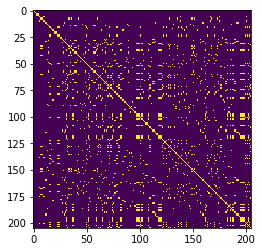

In [6]:
moa_matches = np.asarray(moa_matches)
plt.imshow(moa_matches)

# Enrichment analysis

In [ ]:
results = []
Z = np.asarray(X[Y.Var1])
ut_idx = np.triu_indices(moa_matches.shape[1], k=1)

for p in np.arange(98, 99.7, 0.2):
    r = quality.enrichment_analysis_matrix(Z[ut_idx], moa_matches[ut_idx], p)
    results.append(r)

R = pd.DataFrame(data=results)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(100-R["percentile"], R["ods_ratio"])

# Average precision analysis

In [7]:
def precision_at_k(corr_matrix, moa_matches, rank_pos=None):
    results = []
    is_query = moa_matches.sum(axis=0) > 1
    for i in range(corr_matrix.shape[0]):
        if is_query[i]:
            rank = np.argsort(-corr_matrix[i,:])
            ap = metrics.precision_at_k(moa_matches[i, rank], rank_pos)
            results.append(ap)
    return results

In [8]:
positions = [x for x in range(5,55,5)]
SIM = np.asarray(X[Y.Var1])
average_precision_at_k = [np.mean( precision_at_k(SIM, moa_matches, pos) ) for pos in positions]

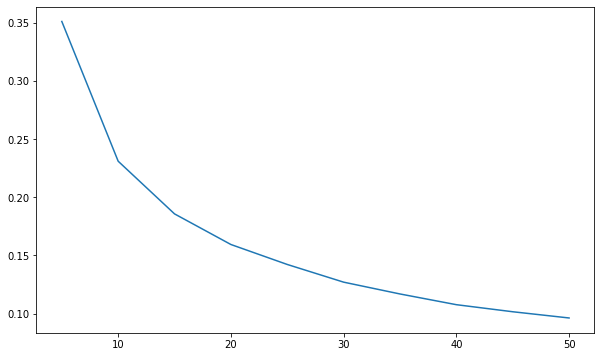

In [9]:
plt.figure(figsize=(10,6))
plt.plot(positions, average_precision_at_k)

In [10]:
top_1percent = max(int(X.shape[0]*0.01), 10)
top_prec = precision_at_k(SIM, moa_matches, top_1percent)
print("Average Precision At Top 1% => ", np.mean(top_prec))

Average Precision At Top 1% =>  0.2308823529411765


# Recall analysis

In [11]:
def recall_at(corr_matrix, moa_matches, rank_pos=None):
    results = []
    is_query = moa_matches.sum(axis=0) > 1
    for i in range(corr_matrix.shape[0]):
        if is_query[i]:
            rank = np.argsort(-corr_matrix[i,:])
            rc = np.sum(moa_matches[i, rank[1:rank_pos]]) / np.sum(moa_matches[i,:])
            results.append(rc)
    return results

In [12]:
recall = [np.mean( recall_at(SIM, moa_matches, pos) ) for pos in positions]

Average Recall - Top 50:  0.298154999741687


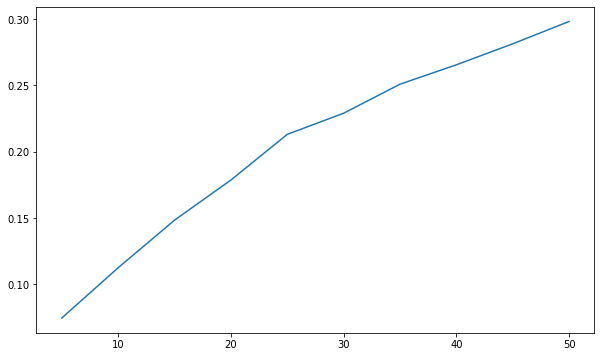

In [13]:
plt.figure(figsize=(10,6))
plt.plot(positions, recall)
print("Average Recall - Top 50: ", np.mean( recall_at(SIM, moa_matches, 50) ))

In [14]:
avg_recall_at_top = np.mean( recall_at(SIM, moa_matches, top_1percent) )
print("Average Recall At Top 1% => ", avg_recall_at_top)

Average Recall At Top 1% =>  0.11261740638675621


# Interpolated Recall-Precision Curve

Mean Average Precision (MAP): 	 0.17107662559340292
Area Under the PR curve: 	 0.17062673038352216


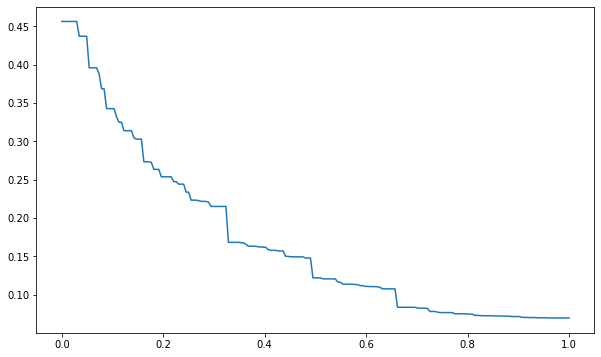

In [15]:
recall_axis, average_precision = metrics.interpolated_precision_recall_curve(moa_matches, SIM)

plt.figure(figsize=(10,6))
plt.plot(recall_axis, average_precision)

print("Mean Average Precision (MAP): \t", np.mean(average_precision))
print("Area Under the PR curve: \t", sklearn.metrics.auc(recall_axis, average_precision))

# Save results

In [ ]:
results = {
    "enrichment": R,
    "ranking": positions,
    "precision_at_k": average_precision_at_k,
    "recall": recall,
    "avg_prec@top1": np.mean(top_prec),
    "avg_recall@top1": avg_recall_at_top,
    "recall_axis": recall_axis,
    "precision_axis": average_precision,
    "mean_average_precision": np.mean(average_precision)
}

# with open(OUT_RESUTS, "bw") as out:
#     pickle.dump(results, out)

In [ ]:
results = []
Z = np.asarray(X[Y.Var1])
ut_idx = np.triu_indices(moa_matches.shape[1], k=1)

threshold = threshold = np.percentile(Z[ut_idx], 99.0)
positives = np.logical_and(Z > threshold, moa_matches)
v11 = np.sum(positives[ut_idx])

annotated_positives = pd.DataFrame(X.Var1)
annotated_positives["Positive_Connections"] = np.sum(positives, axis=1)
annotated_positives

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(positives)